In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from numba import jit
from scipy.integrate import solve_ivp

# Kuramoto Model

We're using $\alpha = 1.457$, $\kappa = 4.0$ and 512 oscillators.

In [6]:
def g(y, κ):
    return κ*np.exp(-κ*np.abs(y))/2

In [204]:
def periodic_distance(x1, x2, length=1):
    return np.minimum(np.abs(x1 - x2), length - np.abs(x1 - x2))

In [143]:
xx, xy = np.meshgrid(np.linspace(0, 1, 512), np.linspace(0, 1, 512))
g_solved = g(periodic_distance(xx, xy), 4)

In [285]:
@jit
def ϕ̇(t, ϕ):
    ϕx, ϕy = np.meshgrid(ϕ, ϕ)
    return - np.sum(g_solved*np.sin(ϕy - ϕx + 1.457), axis=1)/512

In [329]:
ϕ0 = 2*np.pi*np.random.rand(512) - np.pi

In [448]:
%%time
kuramoto_sol = solve_ivp(ϕ̇, (0, 1000), ϕ0, t_eval=np.linspace(0, 1000, 100000), method="RK45")

CPU times: user 15 s, sys: 2.19 s, total: 17.2 s
Wall time: 9.9 s


In [468]:
def drop_phase(phase):
    return (phase + np.pi)%(2*np.pi) - np.pi

In [469]:
kuramoto_y = drop_phase(kuramoto_sol.y)

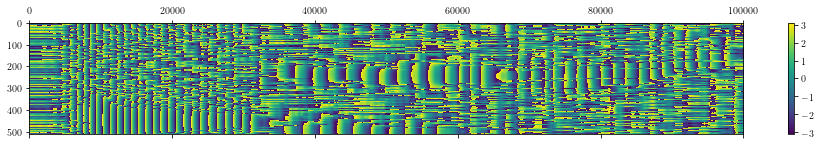

In [470]:
plt.matshow(kuramoto_y, aspect="auto")
plt.colorbar()

(0, 512)

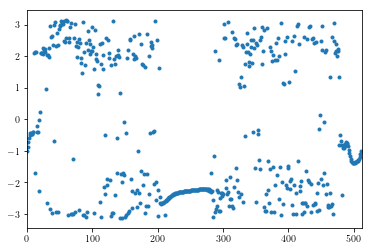

In [471]:
plt.plot(kuramoto_y[:, 60000], ".")
plt.xlim([0, 512])

# Abrams model

In [418]:
μ = 0.6
ν = 0.4
α = np.pi/2 - 0.1

In [419]:
def k1_func(σ):
    return (ν - μ)*(σ - 1) + μ

In [420]:
def k2_func(σ):
    return (μ - ν)*(σ - 1) + ν

In [421]:
σ = np.ones(2048)

In [422]:
σ[1024:] = 2

In [423]:
k1 = k1_func(σ)
k2 = k2_func(σ)

In [475]:
@jit
def θ̇(t, θ):
    θ1x, θ2y = np.meshgrid(θ[:1024], θ[1024:])
    dots = np.empty_like(θ)
    dots[:1024] = μ*np.sum(np.sin(θ1x.T - θ1x - α), axis=0) + ν*np.sum(np.sin(θ2y - θ1x - α), axis=0)
    dots[1024:] = ν*np.sum(np.sin(θ1x.T - θ2y.T - α), axis=0) + μ*np.sum(np.sin(θ2y - θ2y.T - α), axis=0)
    return dots/1024

In [476]:
θ0 = 2*np.pi*np.random.random(2048) - np.pi

In [477]:
%%time
abrams_sol = solve_ivp(θ̇, (0, 3000), θ0, max_step=0.01, t_eval=np.linspace(2000, 3000, 100000), method="RK45")

KeyboardInterrupt: 

In [478]:
abrams_sol.y.shape

(2048, 100000)

In [479]:
abrams_y = drop_phase(abrams_sol.y)

KeyboardInterrupt: 

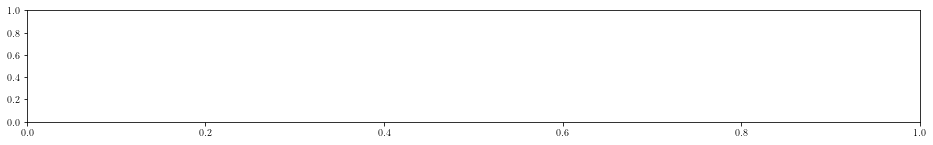

In [481]:
plt.matshow(abrams_y, aspect="auto")
plt.colorbar()

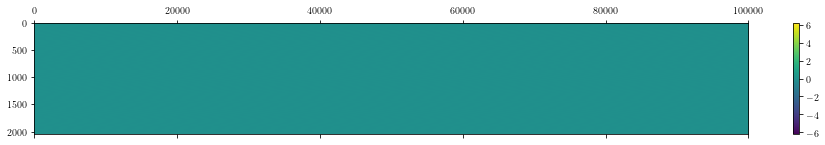

In [480]:
plt.matshow(abrams_y[:, 1:] - abrams_y[:, :-1], aspect="auto")
plt.colorbar()